In [1]:
import numpy as np
from numpy.ctypeslib import ndpointer 

import matplotlib.pyplot as plt
import numba as nb

from tqdm import trange, tqdm
from imageio import imread, imsave
from skimage.measure import label, regionprops
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import threshold_otsu
from skimage.transform import resize

import ctypes 
import os

C:\Temp\ipykernel_13144\4078992883.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imread('circle.png')


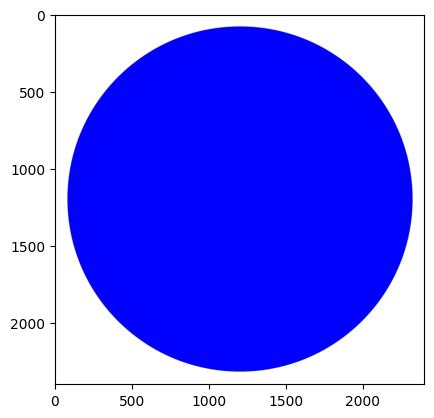

In [21]:
img = imread('circle.png')
plt.imshow(img)

In [22]:
img = img[:, :, :3]

In [24]:
img = resize(img, (512, 512))

In [25]:
def dispersion(x):
    return ((x - x.mean()) ** 2).sum() / x.size

In [26]:
r, g, b = [img[:, :, i] for i in range(3)]
dr, dg, db = map(dispersion, [r, g, b])
mx = max(dr, dg, db)
if mx == dr:
    t = r < threshold_otsu(r)
elif mx == dg:
    t = g < threshold_otsu(g)
else:
    t = b < threshold_otsu(b)

In [27]:
lb = label(t)
big1 = lb == 1
big2 = lb == 0

s1 = big1[0].sum() + big1[-1].sum() + big1[:, 0].sum() + big1[:, -1].sum()
s2 = big2[0].sum() + big2[-1].sum() + big2[:, 0].sum() + big2[:, -1].sum()

if s1 > s2:
    msk = lb == 1
else:
    msk = lb == 0

newmsk = np.zeros((512, 512, 3))
newmsk[~msk, :] = 1
newmsk = newmsk.astype('bool')

img = rgb2hsv(img)

In [28]:
clrs = np.array([[h/50, 0.7, 0.7] for h in range(50)])
clrs = np.vstack((clrs, [[0., 0., 0.], [0., 0., 1.]]))

In [29]:
@nb.njit
def mark(img, itsa):
    nimg = np.zeros_like(img)
    for i in nb.prange(img.shape[0]):
        px = img[i]
        if (px == np.array([0, 0, 0], dtype='float64')).sum() != 3:
            nimg[i] = itsa[np.argmin(np.abs(px - itsa).sum(axis=1))]
    return nimg

In [30]:
clrmsk = mark(img[~msk], clrs)
nimg = np.zeros_like(img)
nimg[~msk] = clrmsk

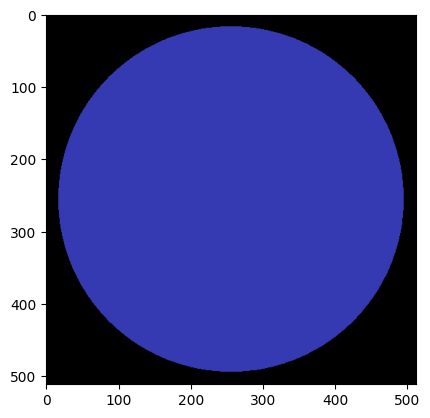

In [31]:
plt.imshow(hsv2rgb(nimg))

In [32]:
from skimage.morphology import binary_dilation, square, remove_small_objects

100%|██████████| 52/52 [00:00<00:00, 69.42it/s]


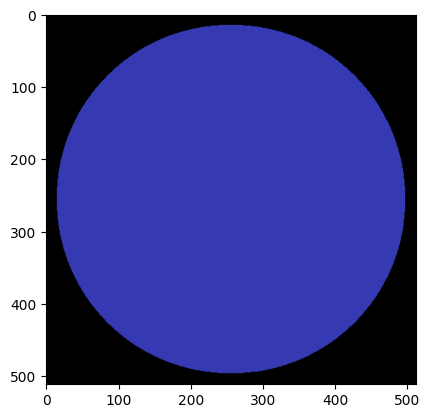

In [33]:
nnimg = nimg.copy()
for color in tqdm(clrs):
    if (color != [0, 0, 0]).any():
        f = (nnimg == color).sum(axis=2) == 3
        if len(np.unique(f)) == 1: continue
        nf = f != remove_small_objects(f, 10)
        
        nnimg[nf] = 0
        f = (nnimg == color).sum(axis=2) == 3
        if len(np.unique(f)) == 1: continue
        # f = remove_small_holes(f, 500)
        f = binary_dilation(f, square(5))
        
        nnimg[f] = color
plt.imshow(hsv2rgb(nnimg))

In [35]:
imsave('colors_circle.png', (hsv2rgb(nnimg) * 255).astype('uint8'))